这个文档的目的是调查MC，KR，GR，CQ之间的正交性，来满足高效和解耦地计算

### 库

In [9]:
import sys
import os
import glob
import pandas as pd
import numpy as np
import itertools
from pathlib import Path
import matplotlib.pyplot as plt
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from Plotting import plot_style_config
from Plotting import ParetoFront_Plotting
from Analysis.analysis_TIMs_with_temperatures import analysis_TIMs_with_temperatures
from Analysis.assisted_functions import load_data
from Analysis.assisted_functions import analyze_correlations
from Analysis.assisted_plotting import plot_scatter
from Analysis.assisted_plotting import plot_bar


### 数据提取

In [26]:
# 提取数据
paths = {
    "MC": "MC_data.csv",
    "KR": "KR_data.csv",
    "GR": "GR_data.csv",
    "CQ": "CQ_data.csv",
}

dfs = {}
for name, p in paths.items():
    df = pd.read_csv(p)
    # 防止 float 温度 merge 误差
    df["temp"] = df["temp"].round(3)
    dfs[name] = df

wide = dfs["MC"]
for name in ["KR", "GR", "CQ"]:
    wide = wide.merge(dfs[name], on=["number", "temp"], how="inner")

wide = wide.sort_values(["number", "temp"]).reset_index(drop=True)

metrics = ["MC", "KR", "GR", "CQ"]
pairs = list(itertools.combinations(metrics, 2))

# 看看Number=196的wide
print(wide[wide["number"] == 180])


      temp        MC  number   KR  GR   CQ
1273  19.1  4.770531     180  116  22   94
1274  19.2  4.861463     180  116  25   91
1275  19.3  4.834536     180  116  23   93
1276  19.4  4.725823     180  117  24   93
1277  19.5  4.794638     180  118  23   95
1278  19.6  4.862100     180  119  22   97
1279  19.7  4.939471     180  119  23   96
1280  19.8  4.847728     180  121  24   97
1281  19.9  4.852313     180  123  22  101
1282  20.0  4.826796     180  123  24   99
1283  20.1  4.859473     180  124  23  101
1284  20.2  4.772923     180  124  23  101
1285  20.3  4.837809     180  124  21  103
1286  20.4  4.705059     180  126  19  107
1287  20.5  4.738561     180  126  19  107
1288  20.6  4.765262     180  127  14  113
1289  20.7  4.695683     180  126  18  108
1290  20.8  4.746852     180  128  12  116
1291  20.9  4.804429     180  129  12  117


In [ ]:
# 处理函数

# 计算标准分数，反映向量中的每个数据距离向量平均值有几个标准差，这个是为了消除不同量纲的影响（均一化）
def zscore(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    mu = np.nanmean(x)
    sd = np.nanstd(x, ddof=1)
    if not np.isfinite(sd) or sd == 0:
        return np.full_like(x, np.nan, dtype=float)
    return (x - mu) / sd

# 计算向量间的余弦相似度
def cosine_similarity_centered(a: np.ndarray, b: np.ndarray) -> float:
    """
    Method-2 orthogonality:
      - within ONE reservoir, treat each metric as a vector across temperatures
      - z-score within that reservoir
      - cosine(z(a), z(b))  (== Pearson correlation)
    """
    # 计算标准分数
    az = zscore(a)
    bz = zscore(b)
    # 去除Nan
    m = np.isfinite(az) & np.isfinite(bz)
    az = az[m]
    bz = bz[m]
    # 如果向量长度小于3，返回Nan
    if len(az) < 3:
        return np.nan
    # 计算余弦相似度
    return float(np.dot(az, bz) / (np.linalg.norm(az) * np.linalg.norm(bz)))

# 计算余弦值对应的夹角
def angle_degrees(cos_val: float) -> float:
    # 如果余弦值不是有限值，返回Nan
    if not np.isfinite(cos_val):
        return np.nan
    # 将余弦值限制在-1到1之间
    cos_val = float(np.clip(cos_val, -1.0, 1.0))
    # 计算夹角
    return float(np.degrees(np.arccos(cos_val)))

# 0度完全正相关，180度完全负相关，90度完全不相关

In [20]:
rows = []
for number, g in wide.groupby("number"):
    g = g.sort_values("temp")
    n_pts = len(g)
    for a, b in pairs:
        cos_ab = cosine_similarity_centered(g[a].to_numpy(), g[b].to_numpy())
        rows.append(
            {
                "number": number,
                "pair": f"{a} vs {b}",
                "cosine": cos_ab,
                "abs_cosine": np.nan if not np.isfinite(cos_ab) else abs(cos_ab),
                "angle_deg": angle_degrees(cos_ab),
                "n_temps": n_pts,
                "temp_min": g["temp"].min(),
                "temp_max": g["temp"].max(),
            }
        )

pairwise = pd.DataFrame(rows)

# 我想看看number=100的pairwise

print(pairwise[pairwise["number"] == 196])

     number      pair    cosine  abs_cosine  angle_deg  n_temps  temp_min  \
462     196  MC vs KR  0.106848    0.106848  83.866374       19      19.1   
463     196  MC vs GR  0.011560    0.011560  89.337633       19      19.1   
464     196  MC vs CQ  0.375286    0.375286  67.957997       19      19.1   
465     196  KR vs GR  0.967834    0.967834  14.571611       19      19.1   
466     196  KR vs CQ  0.120355    0.120355  83.087410       19      19.1   
467     196  GR vs CQ -0.133277    0.133277  97.659021       19      19.1   

     temp_max  
462      20.9  
463      20.9  
464      20.9  
465      20.9  
466      20.9  
467      20.9  


<Axes: xlabel='temp'>

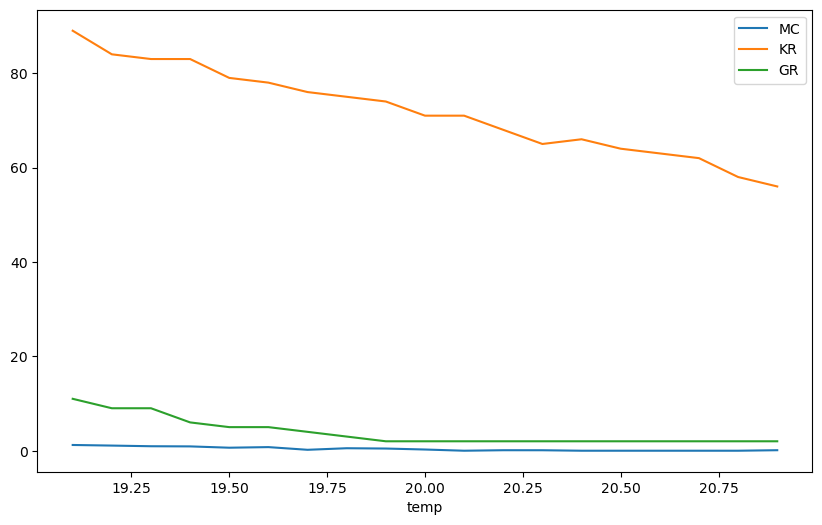

In [28]:
# 看看最解耦的储层（238号）的MC，KR，GR的温度轨迹
wide[wide["number"] == 191][["temp", "MC", "KR", "GR"]].plot(x="temp", y=["MC", "KR", "GR"], figsize=(10, 6))

### 结论：MC,KR,GR,CQ这四个指标空间中没有完美正交性。但是CQ和KR之间有很强的共线性，所以只需要选择其中一个就好。